In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder



## **The dataset is shown below:**

In [2]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 

In [3]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [4]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Feature 0: 0.000000
Feature 1: 0.008512
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.008835
Feature 5: 0.000331
Feature 6: 0.000000
Feature 7: 0.132683
Feature 8: 0.013488
Feature 9: 0.115319
Feature 10: 0.056835
Feature 11: 0.003806
Feature 12: 0.785917
Feature 13: 0.120282
Feature 14: 0.116853
Feature 15: 0.008417
Feature 16: 0.000000
Feature 17: 0.000000
Feature 18: 0.001005
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.002452
Feature 22: 0.002436
Feature 23: 0.005893
Feature 24: 0.010007
Feature 25: 0.000000
Feature 26: 0.051916
Feature 27: 0.029860
Feature 28: 0.017966
Feature 29: 0.050497
Feature 30: 0.145395
Feature 31: 0.006149
Feature 32: 0.091583
Feature 33: 0.026589
Feature 34: 0.000000
Feature 35: 0.065859
12


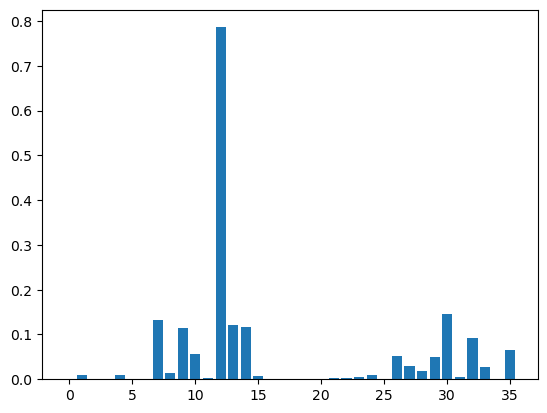

In [18]:
 
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_regression, k=26)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs
 
# load the dataset
# split into train and test sets
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [19]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [20]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

n_samples, n_features = X_train_fs.shape


In [21]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [22]:
model = Model(n_features , 100)


In [ ]:
num_epochs = 10000
learning_rate = 0.01
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

lambda_reg = 0.01

for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train_fs)
    loss = criterion(y_pred, y_train)

    # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


In [26]:
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted = np.array(y_predicted)
    y_predicted = torch.from_numpy(y_predicted.astype(np.float32))
     
    criterion_last = nn.MSELoss()
    loss_last = criterion_last(y_predicted, y_test)
    print(f'loss: {loss_last:.4f}')

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray